#Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
import glob
import imageio
import random, shutil
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display

#Downloading Data

In [ ]:
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

In [ ]:
%%time
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

#Loading Datasets
train_dataset = datasets.ImageFolder(path_imgs, transform = transforms)
val_dataset = datasets.ImageFolder(path_imgs, transform = transforms)
test_dataset = datasets.ImageFolder(path_imgs, transform = transforms)

torch.manual_seed(1)
num_train_samples = len(train_dataset)

# Permute the data
indices = torch.randperm(num_train_samples)

# Split the data into Train and Validation
train_testval_split = 0.2
train_split = int(num_train_samples * train_testval_split)
val_split = int(train_split * 0.5)

train_subset = torch.utils.data.Subset(train_dataset, indices[train_split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[val_split:train_split])
test_subset = torch.utils.data.Subset(test_dataset, indices[:val_split])


print(f"Length of Train:{len(train_subset)}; Length of Val:{len(val_subset)}; Length of Test:{len(test_subset)}")



# Make DataLoaders 
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_subset,
    batch_size=batch_size,
    shuffle=False
)

# Classes
classes = train_dataloader.dataset.dataset.classes

Length of Train:800; Length of Val:100; Length of Test:99
CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 12 ms


In [ ]:
def mean_std(loader):
    images, lebels = next(iter(loader))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

mean, std = mean_std(train_dataloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([ 0.0563, -2.7210, -7.7665]) tensor([1.0046, 2.7263, 7.0552])


In [ ]:
#Remake loaders with data mean and standard deviation values as transformation values
%%time
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[ 0.0563, -2.7210, -7.7665], std=[1.0046, 2.7263, 7.0552])
])

#Loading Datasets
train_dataset = datasets.ImageFolder(path_imgs, transform = transforms)
val_dataset = datasets.ImageFolder(path_imgs, transform = transforms)
test_dataset = datasets.ImageFolder(path_imgs, transform = transforms)

torch.manual_seed(1)
num_train_samples = len(train_dataset)

# Permute the data
indices = torch.randperm(num_train_samples)

# Split the data into Train and Validation
train_testval_split = 0.2
train_split = int(num_train_samples * train_testval_split)
val_split = int(train_split * 0.5)

train_subset = torch.utils.data.Subset(train_dataset, indices[train_split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[val_split:train_split])
test_subset = torch.utils.data.Subset(test_dataset, indices[:val_split])


print(f"Length of Train:{len(train_subset)}; Length of Val:{len(val_subset)}; Length of Test:{len(test_subset)}")



# Make DataLoaders 
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_subset,
    batch_size=batch_size,
    shuffle=False
)

# Classes
classes = train_dataloader.dataset.dataset.classes

Length of Train:800; Length of Val:100; Length of Test:99
CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 12 ms


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
np.random.seed(seed)
path_audio_files = "Data/genres_original/"
path_imgs = "Data/images_original"
batch_size = 32
hop_length = 512
n_fft = 2048
genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

#Define Train Method

In [ ]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader,print_every,num_epoch):
    
    steps = 0
    train_losses, val_losses = [], []
    
    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)
            
            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in val_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()
                        
                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(val_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()
                
                
                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)

        print(f'Epoch took {time() - start_time}') 
        
    return model, train_losses, val_losses

#ResNet18 Model

In [ ]:
# Load a Pretrained Model
resnet18 = models.resnet18(pretrained=True)

# Fix the trainable parameters
for parameter in resnet18.parameters():
    parameter.requires_grad = False
    
    
# Number of Input Features in the Last Fully Connected Layer
in_features = resnet18.fc.in_features

# Replacing the Last Fully Connected Layer
fc = nn.Linear(in_features=in_features, out_features=len(classes))
resnet18.fc = fc


# Updating the Weights and Bias of the last layer
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Define the Loss and Optimizer Functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
resnet18, train_losses, val_losses = train(
    model=resnet18,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    print_every=25,
    num_epoch=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1]/[100]. Batch [25]/[25]. Train loss 2.274. Train acc 15.500. Val loss 2.221. Val acc 12.000. Took 13.419 seconds
Epoch took 13.420408010482788
Epoch [2]/[100]. Batch [25]/[25]. Train loss 0.972. Train acc 32.375. Val loss 1.928. Val acc 32.000. Took 6.305 seconds
Epoch took 6.306377649307251
Epoch [3]/[100]. Batch [25]/[25]. Train loss 0.576. Train acc 43.375. Val loss 1.822. Val acc 35.000. Took 6.286 seconds
Epoch took 6.287393093109131
Epoch [4]/[100]. Batch [25]/[25]. Train loss 0.393. Train acc 54.250. Val loss 1.668. Val acc 44.000. Took 6.481 seconds
Epoch took 6.482987642288208
Epoch [5]/[100]. Batch [25]/[25]. Train loss 0.294. Train acc 56.000. Val loss 1.629. Val acc 42.000. Took 6.460 seconds
Epoch took 6.461678981781006
Epoch [6]/[100]. Batch [25]/[25]. Train loss 0.232. Train acc 58.375. Val loss 1.570. Val acc 49.000. Took 6.400 seconds
Epoch took 6.401785135269165
Epoch [7]/[100]. Batch [25]/[25]. Train loss 0.187. Train acc 61.375. Val loss 1.568. Val acc 55.0

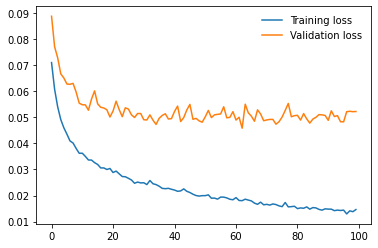

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
#Evaluating on Test Set
y_test = []
y_pred = []
for img, label in test_subset:
    img = torch.Tensor(img)
    img = img.to(device)
    resnet18.eval()
    prediction = resnet18(img[None])
    final_pred = classes[torch.max(prediction, dim=1)[1]]
    y_test.append(label)
    y_pred.append(genre_dict[final_pred])

In [ ]:
print("Accuracy:",(100*(np.array(y_test) == np.array(y_pred)).sum()/len(y_test)))

Accuracy: 71.71717171717172


#ResNet50Model

In [ ]:
# Load a Pretrained Model
resnet50 = models.resnet50(pretrained=True)

# Fix the trainable parameters
for parameter in resnet50.parameters():
    parameter.requires_grad = False
    
    
# Number of Input Features in the Last Fully Connected Layer
in_features = resnet50.fc.in_features

# Replacing the Last Fully Connected Layer
fc = nn.Linear(in_features=in_features, out_features=len(classes))
resnet50.fc = fc


# Updating the Weights and Bias of the last layer
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Define the Loss and Optimizer Functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1]/[100]. Batch [25]/[25]. Train loss 2.196. Train acc 22.375. Val loss 2.551. Val acc 20.000. Took 11.202 seconds
Epoch took 11.204164743423462
Epoch [2]/[100]. Batch [25]/[25]. Train loss 0.867. Train acc 41.625. Val loss 1.798. Val acc 46.000. Took 11.406 seconds
Epoch took 11.407089710235596
Epoch [3]/[100]. Batch [25]/[25]. Train loss 0.500. Train acc 54.750. Val loss 1.605. Val acc 42.000. Took 11.246 seconds
Epoch took 11.247727155685425
Epoch [4]/[100]. Batch [25]/[25]. Train loss 0.335. Train acc 60.375. Val loss 1.395. Val acc 51.000. Took 11.074 seconds
Epoch took 11.075859785079956
Epoch [5]/[100]. Batch [25]/[25]. Train loss 0.253. Train acc 60.375. Val loss 1.484. Val acc 48.000. Took 10.932 seconds
Epoch took 10.933789253234863
Epoch [6]/[100]. Batch [25]/[25]. Train loss 0.206. Train acc 60.250. Val loss 1.345. Val acc 53.000. Took 10.850 seconds
Epoch took 10.851211547851562
Epoch [7]/[100]. Batch [25]/[25]. Train loss 0.164. Train acc 66.250. Val loss 1.287. Va

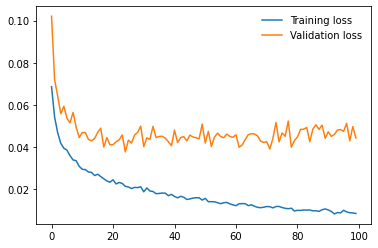

In [ ]:
resnet50, train_losses, val_losses = train(
    model=resnet50,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=25,
    num_epoch=100
)


plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
print("Accuracy:",(100*(np.array(y_test) == np.array(y_pred)).sum()/len(y_test)))

Accuracy: 67.67676767676768


ResNet50 performs worse than ResNet18 with the same hyperparameters due to overfitting on the training sample.

#VGG Model

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)
# Fix the trainable parameters
for parameter in model_vgg16.parameters():
    parameter.requires_grad = False
    
# Updating the Weights and Bias of the last layer
params_to_update = []
for name, param in model_vgg16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
    
num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs,10)

# Define the Loss and Optimizer Functions
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(params_to_update, lr=0.001)
optimizer = torch.optim.SGD(model_vgg16.parameters(), lr=0.01, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
y_test = []
y_pred = []
for img, label in test_subset:
    img = torch.Tensor(img)
    img = img.to(device)
    model_vgg16.eval()
    prediction = model_vgg16(img[None])
    
    final_pred = classes[torch.max(prediction, dim=1)[1]]
    
    y_test.append(label)
    y_pred.append(genre_dict[final_pred])

In [ ]:
print("Accuracy:",(100*(np.array(y_test) == np.array(y_pred)).sum()/len(y_test)))

Accuracy: 53.535353535353536


VGG16 appears to not perform well in the music classiiciation task with the inputted hyperparameters.